# Automating `DL_MONTE` equation of state calculations with `simtask`

*Author: Tom L. Underwood*

## Introduction

`simtask` is a Python package within the `dlmontepython` library for automating complex tasks involving multiple simulations. Here we introduce the package and provide an example illustrating how it could be used. The example involves calculating the energy and density of the Lennard-Jones fluid using grand-canonical Monte Carlo, via the program `DL_MONTE`, for various temperatures *automatically*. The user specifies which temperatures are to be examined, links `simtask` to the relevant `DL_MONTE` executable, and then sets the `simtask` machinery in motion. The result is that plots of energy and density vs. temperature, along with associated statistical uncertainties and taking into account the equilibration time of the simulation, are generated without any input from the user.

## How does `simtask` work?

We now briefly describe the key features of `simtask` with the aim of elucidating how it works. The `simtask.task` module is the heart of the package. This contains the two key Python classes, `Task` and `TaskInterface`.

`Task` - This is the base class corresponding to a simulation 'task', i.e. something you want to do via simulation. E.g. in the example below the 'task' is to evaluate the energy and density via grand-canonical Monte Carlo simulation. `Task` is an abstract class in the sense that it does nothing. It is subclasses of `Task` which correspond to different possible tasks, and contain code for performing these tasks. For instance the `Measurement` class is a subclass of `Task` which calculates one or more observables at a given set of thermodynamic conditions. This is used in our example below. 

The code for `Task` subclasses for performing simulation tasks is *general*; it is not specific to a simulation program, e.g. `DL_MONTE`. This is achieved by `Task` subclasses drawing only upon functions within the `TaskInterface` class for simulation-program-specific code. These functions constitute common things one may wish to do during a task (e.g. copy input files to a new directory, run a simulation in that directory, extract the energy from the output files of a directory), common things which can be combined into complex tasks. To enable `simtask` to be used with a given simulation program, one must write a subclass of `TaskInterface` which overloads the functions in `TaskInterface` with functions which are appropriate for that simulation code. For instance, `DLMonteInterface` is the subclass of `TaskInterface` which contains functions appropriate for the simulation program `DL_MONTE`. To perform a task in conjunction with `DL_MONTE`, the relevant `Task` subclass, e.g. `Measurement`, simply 'links' to the `DLMonteInterface`, which results in `Measurement` calling the `DL_MONTE`-specific functions for the common things during its invocation.

This set-up separates the code pertaining to the task one is interested in performing from the code specific to the simulation program one will use to perform that task. `Task` subclasses will in principle work for *any* simulation program which has an existing `TaskInterface`. Conversely, simulation programs which have an existing `TaskInterface` will work for any future `Task` subclasses.


## Preliminaries

### Installing `dlmontepython`

`simtask` is housed within the `dlmontepython` library (and depends on packages within that library), which can be found at the `dlmontepython` page on [PyPI](https://pypi.org/project/dlmontepython/) or [GitLab](https://gitlab.com/dl_monte/dlmontepython). Hence `dlmontepython` should is a prerequisiste for the examples below. Information on how to install `dlmontepython` can be found at the [GitLab](https://gitlab.com/dl_monte/dlmontepython) page.

Once `dlmontepython` has been installed, and the Python environment configured so that it is 'visible', `simtask` can then be used. The following command imports `simtask`. If `dlmontepython` has been installed and your environment has been configured correctly, this command should run without issue.

In [1]:
import dlmontepython.simtask as simtask

### Installing `DL_MONTE`

Below we use `simtask` to perform Monte Carlo simulations by interfacing simtask with the general-purpose Monte Carlo program `DL_MONTE`. Therefore `DL_MONTE` is another prerequisite for the examples below. See the [DL_MONTE wiki](https://gitlab.com/dl_monte/user-hub) for details regarding how to obtain and install `DL_MONTE`.

## Example 1: Energy and density of Lennard-Jones fluid at a given $\mu$ and $T$

We are now ready to begin the examples. The ultimate aim is to use `simtask` to calculate the energy and density, with associated uncertainties, of the Lennard-Jones fluid for a range of temperatures $T$ at a given chemical potential $\mu$. However we first consider the problem of evaluating these physical quantities at a *single* temperature; in Example 2 later we consider multiple temperatures. 

More specifically, we will use `simtask.measurement` to perform back-to-back grand-canonical Monte Carlo simulations with `DL_MONTE` until one of two criteria are met: 1) the energy and density (in fact, the mean number of particles in the system) are evaluated to a specified *precision*; 2) a threshold number of back-to-back simulations have been performed. Note that by 'back-to-back' we mean that the next simulation begins in the configuration where the previous simulation ended.

To perform a standard grand-canonical `DL_MONTE` simulation three `DL_MONTE` input files are required, `CONTROL`, `CONFIG` and `FIELD`. The relevant files can be found in the directory housing this notebook. A fuller account of the significance of the contents of the input files can be found elsewhere, e.g. the `DL_MONTE` user manual (see the [DL_MONTE wiki](https://gitlab.com/dl_monte/user-hub) for links). We discuss the contents of these files only briefly here. Moreover we do not provide here an account of grand-canonical Monte Carlo or Monte Carlo simulation methodology, further details of which can be found elsewhere. We assume the reader has a basic understanding of grand-canonical Monte Carlo and how to run grand-canonical simulations in `DL_MONTE`.

### Simulation details

The input files CONTROL, CONFIG and FIELD correspond to a grand-canonical Monte Carlo simulation of the Lennard-Jones fluid as follows. The reduced temperature is $T^*=1.55112$ and the thermodynamic activity is $z=0.04$, where $T^*\equiv k_BT/\epsilon$, $z\equiv\exp(\mu/(k_BT))$, and $\epsilon$ denotes the well depth of the Lennard-Jones potential. Note that the $T^*$ considered is above the critical temeprature (which is $T_c^*=1.326$). The system is a cube with sides of length $10\sigma$, where $\sigma$ is the interparticle separation at which the Lennard-Jones is zero. The potential is truncated at a distance of $2.5\sigma$, and no tail corrections are applied. The Monte Carlo move-set is comprised only of insertion and deletion moves; no translation moves were applied. Finally, the length of the simulation is 120,000 moves. (Note however that back-to-back simulations will be performed; hence considerably more moves than 120,000 will be used in total).

### Configuring the output of `simtask`

We will now describe the `simtask` Python commands required to perform the task at hand. First of all we should import the relevant `simtask` modules. We also import the `logging` module (a standard library module), since `simtask` uses this module to control its output. The aim of `simtask` is to perform a complicated task involving multiple simulations. During such a task, `simtask` outputs information, via the `logging` module, regarding the progress of the task for the benefit of the user. `logging` enables the 'level' of output to be controlled. For debugging one would typically desire more information to be output; for very long tasks one would typically want a more succint description of the progress of the task. This is all covered by the below code snippet.

In [2]:
import logging

# Import simtask modules used later
import dlmontepython.simtask.dlmonteinterface as interface
import dlmontepython.simtask.measurement as measurement
import dlmontepython.simtask.analysis as analysis
import dlmontepython.simtask.task as task

# Set up the logger, which determines the nature of information output by the 
# machinery in the 'simtask' package. The line below results in logging 
# information being output to stdout

handler = logging.StreamHandler()

# Below we set up the 'logger' in simtask.measurement, to determine the nature 
# of output when the 'measurement' module is used (see below). Replacing 
# 'logging.INFO' with 'logging.DEBUG' below results in more information being 
# output by the logger. Using 'logging.WARNING' results in less information 
# being output: only 'warnings'

measurement.logger.setLevel(logging.INFO)
measurement.logger.addHandler(handler)

### Linking to the `DL_MONTE` executable

We now set up the relevant `TaskInterface` object, which tells the low-level machinery in `simtask` which simulation program will be used to perform the simulations, and how to perform various jobs specific to that program, e.g. extracting the energy from output files created by the program. In this case we use `DL_MONTE` to perform our simulations; thus the `TaskInterface` class we will use is `DLMonteInterface` (`DLMonteInterface` is a subclass of `TaskInterface`; see above). The code below creates a new `DLMonteInterface` object, which is linked to the relevant `DL_MONTE` executable. Later this object will be 'linked' to the relevant `Task` object before the task is performed.

Note that the `DLMonteInterface` object must be provided the location and name of the `DL_MONTE` executable on your local system. In the example below 'DL_MONTE-SRL.X' is used as a placeholder; you must alter that string in the code below to reflect your local system.

In [3]:
# The line below creates a DL_MONTE-specific interface. Note that the interface 
# must know the location of the DL_MONTE executable - which is specified as the 
# argument to the DLMonteInterface constructor.
# You will have to adapt the location of the executable to suit your local system.

interface = interface.DLMonteInterface("DLMONTE-SRL.X")

### Setting up the `Measurement` object

We will use the `Measurement` class to automate the task of calculating the energy and number of molecules for various given chemical potentials.  We will set up a `Measurement` object, `m`, and then begin the task with the command 

```python
m.run()
```

#### Task observables

The `Measurement` constructor requires a list of `Observable` objects (see below), which represent the physical quantities to be tracked during the task. We are interested in the energy and number of particles. Below we create a list `observables` accordingly.

In [4]:
energy_obs = task.Observable( ("energy",) )
nmol_obs = task.Observable( ("nmol",0) )
observables = [ energy_obs, nmol_obs ]

Note that the nature of `Observable` objects may vary between simulation codes. For `DL_MONTE` only observables corresponding to variables output periodically in the `YAMLDATA` file are currently supported. For a variable 'foo' specified in the `YAMLDATA` file the corresponding `Observable` object is returned by the command 

```python
task.Observable( ("foo",) )
```

Note the essential comma after `"foo"`! For a variable in `YAMLDATA` which is an array (e.g., 'nmol'), the observable corresponding to the `n`th element in the array is returned by the command

```python
task.Observable( ("foo",n-1) )
```

See the code snippet above: `energy_obs` corresponds to the 'energy' variable in `YAMLDATA`, and `nmol_obs` corresponds to the 1st element in the 'nmol' array in `YAMLDATA` (which in fact is the number of molecules belonging to the 1st molecular species).

#### Termination criteria

The `Measurement` class will perform back-to-back simulations until one of a number of customisable criteria have been met. The criteria are determined by the arguments passed to the constructor of the `Measurement` object. For now we apply two criteria. The first is that the energy is evaluated to a precision of 0.2 (energy units), i.e. the back-to-back simulations are terminated if the statistical uncertainty in the energy is less than this precision. The second criterion is that the number of back-to-back simulations does not exceed 20. The below code creates a `Measurement` object with the aforementioned criteria. Moreover we set the name of the directory in which the simulations are to be performed as `fixedprecision`.

In [5]:
# A dictionary is used to specify the threshold precisions to apply to the observables. Here we only
# specify a threshold precision for the energy observable: the simulations will terminate when the energy is
# determined to an uncertainty less than 0.2 (energy units). Note that there is no entry in the dictionary
# corresponding to the 'nmol' observable. The significance of this is that there is no threshold precision
# for this observable.

precisions = { energy_obs : 0.2 }

# Set up the relevant Measurement object - which will actually perform the simulations and data analysis.
# Note that all the simulations and output files pertaining to analysis will be created in the directory
# 'fixedprecision' (via the 'outputdir' argument), and that we will impose a threshold precision on the
# energy as implied by the dictionary 'precisions' described above. Furthermore, we specify that no more
# than 20 simulations will ever be performed (via the 'maxsims' argument)

m = measurement.Measurement(interface, observables, maxsims=20, precisions=precisions, outputdir='fixedprecision')

### Running the task

As mentioned above, the task is invoked via the command

```python
m.run()
```

Note that when this is called, information is generated and output to stdout at a level set earlier in the discussion pertaining to the `logging` module. At completion of the task 'Completed measurement task' is output (for the default level of output used in the `logging` module).

#### Troubleshooting

If you encounter a problem with running the next block of code, one possible reason is that the path to the `DL_MONTE` executable used to initialise the `DLMonteInterface` object above does not exist, or is wrong.

In [6]:
# Remove the old directory 'fixedprecision', if it exists, before running the task:
# the task will not run if the directory already exists; it will not be overwritten.

import os
import shutil

if os.path.exists('fixedprecision'):
    shutil.rmtree('fixedprecision')


# Run the task

m.run()


Beginning measurement task...


Beginning simulations...


On simulation 1 of max. 20...

Setting up directory 'fixedprecision/sim_1' for simulation...
Running simulation in 'fixedprecision/sim_1'...


execute  DLMONTE-SRL.X
directory fixedprecision/sim_1


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 1200
  statistical inefficiency = 4.118911729650304
  correlation time = 2.0183356620327406
  calculated block size = 21
Calculating block averages...
  number of blocks found = 57
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0
  mean from block averages = -16.200312945363038
  std. error from block averages = 0.5066957166897814

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: e

execute  DLMONTE-SRL.X
directory fixedprecision/sim_2


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 2400
  statistical inefficiency = 3.7941466966530344
  correlation time = 1.8523013025766628
  calculated block size = 19
Calculating block averages...
  number of blocks found = 126
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0673172173530439
  mean from block averages = -15.77194780067753
  std. error from block averages = 0.33435818760610697

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equi

execute  DLMONTE-SRL.X
directory fixedprecision/sim_3


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 3600
  statistical inefficiency = 3.6051369641849225
  correlation time = 1.7553493729760743
  calculated block size = 18
Calculating block averages...
  number of blocks found = 200
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0563488152000882
  mean from block averages = -15.766528507815286
  std. error from block averages = 0.2571929257621618

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equi

execute  DLMONTE-SRL.X
directory fixedprecision/sim_4


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 4800
  statistical inefficiency = 3.738324499509048
  correlation time = 1.8236948301744929
  calculated block size = 19
Calculating block averages...
  number of blocks found = 252
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.296362972743758
  mean from block averages = -15.776110314467514
  std. error from block averages = 0.2582645144959758

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equili

execute  DLMONTE-SRL.X
directory fixedprecision/sim_5


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 6000
  statistical inefficiency = 3.731514955169405
  correlation time = 1.8202037209479276
  calculated block size = 19
Calculating block averages...
  number of blocks found = 315
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.3441928671727235
  mean from block averages = -15.795423544366155
  std. error from block averages = 0.23228473457913698

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equi

execute  DLMONTE-SRL.X
directory fixedprecision/sim_6


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 7200
  statistical inefficiency = 3.6987063408632124
  correlation time = 1.8033787052943786
  calculated block size = 19
Calculating block averages...
  number of blocks found = 378
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.1273175025844357
  mean from block averages = -15.836595784452435
  std. error from block averages = 0.196725235333377

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equil

### Analysing the output

During the task the simulations are performed in subdirectories of the directory `fixedprecision` earmarked as the workspace for the task. The first simulation is performed in subdirectory `sim_1`, the second in `sim_2`, etc. The task involved 6 simulations before the task was terminated on account of the threshold energy being reached. Thus within `fixedprecision` there are thus 6 subdirectories, one corresponding to each simulation. Moreover there are two files, `energy_converge.dat` and `nmol_0_converge.dat`. These contain plots of the observables and their uncertainties obtained after each simulation: the first column in each file corresponds to the simulation number, the second to the mean value of the observable, and the third to the uncertainty. Note that data is pooled from all simulations up to that point in order to come up with the mean and uncertainty. Furthermore the mean and uncertainty are calculated only using post-equilibration data: an algorithm is used to detect when the system has equilibrated, and data obtained before that is ignored in calculating the mean and uncertainty. Details of how the mean and uncertainty are calculated, and how equilibration is detected, is beyond the scope of this document; see the source code for details.

Below we plot the data in the `energy_converge.dat` and `nmol_0_converge.dat` files. Note that the uncertainty in the energy and number of molecules decreases with each subsequent simulation. This reflects the fact that each subsequent simulation brings more data, enabling the energy and number of molecules to be determined to a higher precision.

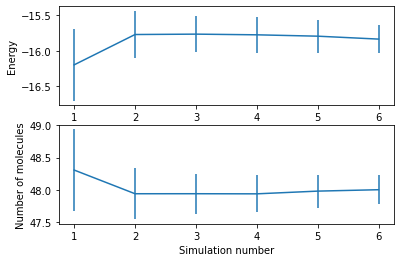

In [42]:
import numpy as np
import matplotlib.pyplot as plt

E_data = np.loadtxt("fixedprecision/energy_converge.dat")
N_data = np.loadtxt("fixedprecision/nmol_0_converge.dat")

plt.subplot(2,1,1)
plt.errorbar(E_data[:,0],E_data[:,1],yerr=E_data[:,2])
plt.xlabel("Simulation number")
plt.ylabel("Energy")

plt.subplot(2,1,2)
plt.errorbar(N_data[:,0],N_data[:,1],yerr=N_data[:,2])
plt.xlabel("Simulation number")
plt.ylabel("Number of molecules")

plt.show()

## Example 2: Energy and density of Lennard-Jones fluid at a given $\mu$ vs. $T$

Example 1 demonstrated how `simtask` could be used to calculate the value and uncertainty of an observable automatically at a given set of thermodynamic conditions: the energy and density was calculated at a specified chemical potential and temperature. We will now go further, automating the calculation of the energy and density at *many* temperatures.
The relevant `simtask` class is `MeasurementSweep`, which performs sets of simulations similar to that performed by `Measurement` at a list of different *control parameters*.

Similarly to `Measurement`, to invoke the task corresponding to a `MeasurementSweep` object `sweep` the command is

```python
sweep.run()
```

However, first one must create the object `sweep`, parameterised appropriately for the task at hand.

### Setting up the Measurement object

First of all we must make a *template* `Measurement` object which will determine the nature of the calculations of energy and density at each temperature: the calculations at each temperature will track the same observables, and have the same termination criteria, as that of the template `Measurement` object. We make a template with the same observables and `TaskInterface` object (pertaining to `DL_MONTE`) as before. However this time we will use slightly different termination criteria. Instead of using the precision of the energy as a termination criterion, we will impose a maximum time of 30s to the task (i.e. if 30s has elapsed, then no further simulations will be performed beyond the current one). Thus the template `Measurement` object is created as follows.

In [7]:
measurement_template = measurement.Measurement(interface, observables, maxsims=20, maxtime=30)

Note that a maximum number of simulations of 20 is still a termination criterion, as it was in Example 1.

The next step is to create a list of control parameters - in this case temperature - to examine.

In [8]:
temperatures = [8000,9000,10000,11000,12000,13000,14000,15000,16000,17000]

Finally we create the `MeasurementSweep` object `sweep` which will actually perform all the simulations and data analysis. The following command achieves this. Note that the list of control parameters is passed to the argument `paramvalues`. Note also that a string `"temperature"` has been passed to the argument `param`, which is the name of the control parameter. The result is that the `DLMonteInterface` object `interface`, which will create and modify `DL_MONTE` input files during the task, 'knows' to treat the temperature as a control parameter during the task. More specifically, in order to modify the input files appropriately for the next control parameter to be considered, it will search for the keyword `"temperature"` in the `DL_MONTE` input file `CONTROL`, and then modify the value of the temperature next to that keyword. Finally, we should mention that the name of the directory in which all simulations are to be performed is set to `fixedtimesweep`.

In [9]:
sweep = measurement.MeasurementSweep(param="temperature", paramvalues=temperatures,
                                     measurement_template=measurement_template, outputdir="fixedtimesweep")

### Running the task

As mentioned above, the task is invoked via the command

```python
sweep.run()
```

Note that when this is called, information is generated and output to stdout at a level set earlier in the discussion pertaining to the `logging` module.

Since we are considering 10 temperatures, and have imposed a time limit of 30 s for all simulations at a given temperature, we expect that the whole task should take about 300s = 5min to perform. 

In [10]:
# Remove the old directory 'fixedprecision', if it exists, before running the task:
# the task will not run if the directory already exists; it will not be overwritten.
import os
import shutil

if os.path.exists('fixedtimesweep'):
    shutil.rmtree('fixedtimesweep')

# Run the task
    
sweep.run()


Beginning measurement sweep task...


Beginning measurement for control parameter value 8000...

Setting up directory 'fixedtimesweep/param_8000' for control parameter value 8000...
Running measurement for control parameter 8000...

Beginning measurement task...


Beginning simulations...


On simulation 1 of max. 20...

Setting up directory 'fixedtimesweep/param_8000/sim_1' for simulation...
Running simulation in 'fixedtimesweep/param_8000/sim_1'...


execute  DLMONTE-SRL.X
directory fixedtimesweep/param_8000/sim_1


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 1200
  statistical inefficiency = 276.26486268501736
  correlation time = 138.13182805460738
  calculated block size = 1382
Calculating block averages...
  number of blocks found = 0
Analysing block averages for observable 'energy' (for mean and standard error)...
Cannot calculate mean: we need >= 1 post-equlibration block

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging.

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_8000/sim_2


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 2400
  statistical inefficiency = 476.01580298126777
  correlation time = 238.00755136178915
  calculated block size = 2381
Calculating block averages...
  number of blocks found = 1
Analysing block averages for observable 'energy' (for mean and standard error)...
Cannot calculate standard error: we need >= 2 post-equilibration blocks
Results of analysis of block averages:
  statistical inefficiency of block averages = [nan]
  mean from block averages = -2694.410466683856
  std. error from block averages = nan

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time serie

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_8000/sim_3


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 3600
  statistical inefficiency = 655.9210533645663
  correlation time = 327.9602725865085
  calculated block size = 3280
Calculating block averages...
  number of blocks found = 1
Analysing block averages for observable 'energy' (for mean and standard error)...
Cannot calculate standard error: we need >= 2 post-equilibration blocks
Results of analysis of block averages:
  statistical inefficiency of block averages = [nan]
  mean from block averages = -2800.820151760096
  std. error from block averages = nan

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series 

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_9000/sim_1


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 1200
  statistical inefficiency = 281.61690707052384
  correlation time = 140.80786171274366
  calculated block size = 1409
Calculating block averages...
  number of blocks found = 0
Analysing block averages for observable 'energy' (for mean and standard error)...
Cannot calculate mean: we need >= 1 post-equlibration block

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging.

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_9000/sim_2


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 2400
  statistical inefficiency = 501.3063739072374
  correlation time = 250.65285448857765
  calculated block size = 2507
Calculating block averages...
  number of blocks found = 0
Analysing block averages for observable 'energy' (for mean and standard error)...
Cannot calculate mean: we need >= 1 post-equlibration block

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging..

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_9000/sim_3


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 3600
  statistical inefficiency = 625.3434419027029
  correlation time = 312.67145443096075
  calculated block size = 3127
Calculating block averages...
  number of blocks found = 1
Analysing block averages for observable 'energy' (for mean and standard error)...
Cannot calculate standard error: we need >= 2 post-equilibration blocks
Results of analysis of block averages:
  statistical inefficiency of block averages = [nan]
  mean from block averages = -2724.224786475014
  std. error from block averages = nan

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_10000/sim_1


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 1200
  statistical inefficiency = 291.108198357725
  correlation time = 145.5535266522481
  calculated block size = 1456
Calculating block averages...
  number of blocks found = 0
Analysing block averages for observable 'energy' (for mean and standard error)...
Cannot calculate mean: we need >= 1 post-equlibration block

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...


execute  DLMONTE-SRL.X
directory fixedtimesweep/param_10000/sim_2


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 2400
  statistical inefficiency = 460.8052744742667
  correlation time = 230.40227555100574
  calculated block size = 2305
Calculating block averages...
  number of blocks found = 1
Analysing block averages for observable 'energy' (for mean and standard error)...
Cannot calculate standard error: we need >= 2 post-equilibration blocks
Results of analysis of block averages:
  statistical inefficiency of block averages = [nan]
  mean from block averages = -2532.892484150923
  std. error from block averages = nan

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_10000/sim_3


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 3600
  statistical inefficiency = 639.5306706979877
  correlation time = 319.76507474104227
  calculated block size = 3198
Calculating block averages...
  number of blocks found = 1
Analysing block averages for observable 'energy' (for mean and standard error)...
Cannot calculate standard error: we need >= 2 post-equilibration blocks
Results of analysis of block averages:
  statistical inefficiency of block averages = [nan]
  mean from block averages = -2668.1912916401643
  std. error from block averages = nan

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time serie

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_11000/sim_1


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 1200
  statistical inefficiency = 453.7270403570897
  correlation time = 226.86315285002215
  calculated block size = 2269
Calculating block averages...
  number of blocks found = 0
Analysing block averages for observable 'energy' (for mean and standard error)...
Cannot calculate mean: we need >= 1 post-equlibration block

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging..

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_11000/sim_2


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 2400
  statistical inefficiency = 671.5384900918816
  correlation time = 335.7689968594715
  calculated block size = 3358
Calculating block averages...
  number of blocks found = 0
Analysing block averages for observable 'energy' (for mean and standard error)...
Cannot calculate mean: we need >= 1 post-equlibration block

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_12000/sim_1


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 1200
  statistical inefficiency = 79.80101790146344
  correlation time = 39.89842033518845
  calculated block size = 399
Calculating block averages...
  number of blocks found = 3
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0
  mean from block averages = -59.95688453471485
  std. error from block averages = 10.035551801194137

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: equ

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_12000/sim_2


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 2400
  statistical inefficiency = 63.67489405070411
  correlation time = 31.83482939037445
  calculated block size = 319
Calculating block averages...
  number of blocks found = 7
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0
  mean from block averages = -57.973721355242034
  std. error from block averages = 5.317427718733239

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: equ

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_12000/sim_3


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 3600
  statistical inefficiency = 71.58335824998592
  correlation time = 35.78935071591705
  calculated block size = 358
Calculating block averages...
  number of blocks found = 10
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.2507317357899104
  mean from block averages = -57.69225194780701
  std. error from block averages = 4.435747866694548

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibr

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_13000/sim_1


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 1200
  statistical inefficiency = 11.240107495247997
  correlation time = 5.6051944665045035
  calculated block size = 57
Calculating block averages...
  number of blocks found = 21
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0
  mean from block averages = -35.33800893482749
  std. error from block averages = 1.4966519642202478

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: e

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_13000/sim_2


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 2400
  statistical inefficiency = 11.962758412914502
  correlation time = 5.967421023111753
  calculated block size = 60
Calculating block averages...
  number of blocks found = 40
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.086263501780917
  mean from block averages = -35.0007884513453
  std. error from block averages = 1.0380843286491517

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibra

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_13000/sim_3


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 3600
  statistical inefficiency = 13.040368895454879
  correlation time = 6.507383518910549
  calculated block size = 66
Calculating block averages...
  number of blocks found = 54
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0
  mean from block averages = -35.28974916866478
  std. error from block averages = 0.9673948410888297

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: eq

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_14000/sim_1


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 1200
  statistical inefficiency = 10.550210876388965
  correlation time = 5.259269939269394
  calculated block size = 53
Calculating block averages...
  number of blocks found = 22
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0
  mean from block averages = -27.326360982930076
  std. error from block averages = 1.3273456859353725

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: e

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_14000/sim_2


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 2400
  statistical inefficiency = 9.949467864683712
  correlation time = 4.957937252279831
  calculated block size = 50
Calculating block averages...
  number of blocks found = 48
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.2137656170771918
  mean from block averages = -27.70697454448202
  std. error from block averages = 0.9370523272837954

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibr

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_14000/sim_3


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 3600
  statistical inefficiency = 9.166428063077507
  correlation time = 4.5649736720568335
  calculated block size = 46
Calculating block averages...
  number of blocks found = 78
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.2376027698793002
  mean from block averages = -27.616258245427105
  std. error from block averages = 0.7997021055710672

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equili

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_15000/sim_1


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 1200
  statistical inefficiency = 4.52787285318643
  correlation time = 2.2266359711631747
  calculated block size = 23
Calculating block averages...
  number of blocks found = 52
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 2.0238528291760716
  mean from block averages = -21.76492577680058
  std. error from block averages = 0.8738332786850798

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibr

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_15000/sim_2


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 2400
  statistical inefficiency = 4.738283224881231
  correlation time = 2.333539303834217
  calculated block size = 24
Calculating block averages...
  number of blocks found = 100
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.4146672858044402
  mean from block averages = -21.718695722771876
  std. error from block averages = 0.5491266877775554

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equili

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_15000/sim_3


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 3600
  statistical inefficiency = 4.994839809991934
  correlation time = 2.4636877874316103
  calculated block size = 25
Calculating block averages...
  number of blocks found = 144
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0787507603945306
  mean from block averages = -21.927503993132714
  std. error from block averages = 0.42921001114117696

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equi

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_16000/sim_1


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 1200
  statistical inefficiency = 5.0129741070953235
  correlation time = 2.4728796391364063
  calculated block size = 25
Calculating block averages...
  number of blocks found = 48
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0
  mean from block averages = -19.036871749056417
  std. error from block averages = 0.5752877492695871

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: 

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_16000/sim_2


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 2400
  statistical inefficiency = 4.421077987599448
  correlation time = 2.172312219781399
  calculated block size = 22
Calculating block averages...
  number of blocks found = 109
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0901343574134152
  mean from block averages = -19.308958046360576
  std. error from block averages = 0.41273198053162513

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equil

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_16000/sim_3


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 3600
  statistical inefficiency = 4.944938089616235
  correlation time = 2.4383888899800428
  calculated block size = 25
Calculating block averages...
  number of blocks found = 144
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0
  mean from block averages = -19.307370198405035
  std. error from block averages = 0.35264244123373695

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test:

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_17000/sim_1


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 1200
  statistical inefficiency = 4.522502075020834
  correlation time = 2.223905084880934
  calculated block size = 23
Calculating block averages...
  number of blocks found = 52
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0970576009857433
  mean from block averages = -17.234607688988497
  std. error from block averages = 0.47878043920008906

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equili

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_17000/sim_2


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 2400
  statistical inefficiency = 3.5133053920547908
  correlation time = 1.708143196514686
  calculated block size = 18
Calculating block averages...
  number of blocks found = 133
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0
  mean from block averages = -17.29768065594026
  std. error from block averages = 0.32858794433367533

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equilibration test: 

execute  DLMONTE-SRL.X
directory fixedtimesweep/param_17000/sim_3


Simulation complete

Extracting data for observable 'energy'...
Extraction complete
Analysing time series for observable 'energy'...
Bypassing equilibration test: equilibration assumed from outset
System is deemed equilibrated
  equilibration time = 0
Deducing blocks to use for block averaging...
Results of post-equilibration time series analysis for observable 'energy':
  number of data points = 3600
  statistical inefficiency = 3.541251680162954
  correlation time = 1.7225166051077843
  calculated block size = 18
Calculating block averages...
  number of blocks found = 200
Analysing block averages for observable 'energy' (for mean and standard error)...
Results of analysis of block averages:
  statistical inefficiency of block averages = 1.0201406286977115
  mean from block averages = -17.247188481284052
  std. error from block averages = 0.26873339273154034

Extracting data for observable 'nmol_0'...
Extraction complete
Analysing time series for observable 'nmol_0'...
Bypassing equi

### Analysing the output

During the task the simulations are performed in subdirectories of the directory `fixedtimesweep` earmarked as the workspace for the task. The simulations corresponding to control parameter (i.e. temperature) 8000 were performed in the subdirectory `param_8000`, the simulations corresponding to control parameter 9000 were performed in subdirectory `param_9000`, etc. There were 10 control parameters considered, and hence there are 10 such `param_` subdirectories. Moreover there are two files, `energy_sweep.dat` and `nmol_0_sweep.dat`. These contain plots of the observables and their uncertainties obtained at each control parameter vs. control parameter: the first column in each file corresponds to the control parameter, the second to the mean value of the observable, and the third to the uncertainty. As with Example 1, the post-equilibration data from the multiple simulations performed at each control parameter are pooled in order to come up with the final mean and uncertainty. 

Note that some of the uncertainties have value `nan`. This signifies that not enough post-equilibration data was gathered given the constraints (i.e. the finite time limit of 30s we imposed to examine each temperature) for an uncertainty to be calculated. Similar would apply to mean values if that were the case.

Below we plot the data in the `energy_sweep.dat` and `nmol_0_sweep.dat` files. Note that, as expected, the energy of the system increases, and the number of molecules in the system decreases, with increasing temperature.

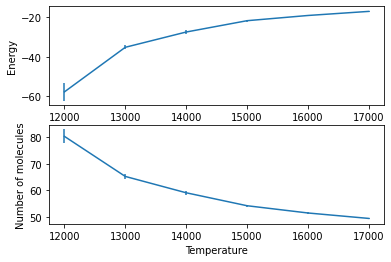

In [63]:
import numpy as np
import matplotlib.pyplot as plt

E_data = np.loadtxt("fixedtimesweep/energy_sweep.dat")
N_data = np.loadtxt("fixedtimesweep/nmol_0_sweep.dat")


# Keep only the data points which don't have nan as an uncertainty
# (using boolean array indexing)
E_data = E_data[~np.isnan(E_data[:,2]),:]
N_data = N_data[~np.isnan(N_data[:,2]),:]

plt.subplot(2,1,1)
plt.errorbar(E_data[:,0],E_data[:,1],yerr=E_data[:,2])
plt.xlabel("Temperature")
plt.ylabel("Energy")

plt.subplot(2,1,2)
plt.errorbar(N_data[:,0],N_data[:,1],yerr=N_data[:,2])
plt.xlabel("Temperature")
plt.ylabel("Number of molecules")

plt.show()
